<a href="https://colab.research.google.com/github/quarcs-lab/pysalnarsc19/blob/master/content/210_geopandas_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction to GeoPandas
=========================

The second library in the Python geospatial stack that we examine is
[GeoPandas](http://geopandas.org/). GeoPandas builds on the capabilities
of Shapely and combines these with the popular
[pandas](http://pandas.pydata.org) library that provides
high-performance and easy-to-use data structures for data analysis in
Python.

Objectives
----------

-   Understand GeoDataSeries and GeoDatatFrames
-   Learn reading and writing common vector spatial data formats
-   Carry out geoprocessing with GeoPandas


# Preliminarities

## Install libraries

In [0]:
#!pip install -q geopandas
!pip install -q seaborn
!pip install -q shapely


In [67]:
%%time 
!apt install -qq gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install -qq python3-rtree 
# Install Geopandas
!pip install -qq git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install -qq descartes 

gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-430 linux-headers-4.15.0-76 linux-headers-4.15.0-76-generic
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
python3-rtree is already the newest version (0.8.3+ds-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-430 linux-headers-4.15.0-76 linux-headers-4.15.0-76-generic
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
CPU times: user 452 ms, sys: 80.8 ms, total: 533 ms
Wall time: 36.4 s


In [119]:
!apt install libspatialindex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libspatialindex


## Load libraries

In [0]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

In [0]:
import os
import rtree

## Load data from Github 

In [0]:
# It will be cloned for about a 12 hours. That is, you have to re-run this code only after 12 hours
# !git clone --recursive https://github.com/quarcs-lab/pysalnarsc19.git

In [71]:
# Let us see what we have inside content/data Folder
 !ls pysalnarsc19/content/data

airbnb.cpg			  participants2016.csv
airbnb.dbf			  participants2017.csv
airbnb.prj			  participants2018.csv
airbnb.shp			  README.md
airbnb.shx			  riverside_city.dbf
airports.csv			  riverside_city.prj
b500.cpg			  riverside_city.qpj
b500.dbf			  riverside_city.shp
b500.prj			  riverside_city.shx
b500.shp			  san_diego.cpg
b500.shx			  san_diego.dbf
behavioralHealth.dbf		  san_diego.prj
behavioralHealth.prj		  san_diego.shp
behavioralHealth.qpj		  san_diego.shx
behavioralHealth.shp		  san_diego.tif
behavioralHealth.shx		  sd_tracts_acs_clean.dbf
CAINC1__ALL_STATES_1969_2017.csv  sd_tracts_acs_clean.prj
CAINC1__definition.xml		  sd_tracts_acs_clean.qpj
CAINC1__Footnotes.html		  sd_tracts_acs_clean.shp
california_tracts.cpg		  sd_tracts_acs_clean.shx
california_tracts.dbf		  texas.dbf
california_tracts.prj		  texas.geojson
california_tracts.shp		  texas.prj
california_tracts.shx		  texas.qgs
city_tracts.cpg			  texas.qpj
city_tracts.dbf			  texas.shp
city_tracts.prj			  texas.shx
city_t

In [0]:
# Load data (from cloned repository)
# db = geopandas.read_file('pysalnarsc19/content/data/texas.shp')

GeoPandas Structure
===================

As mentioned above, geopandas builds on-top of shapely which means we
have access to all the functionality we saw in the previous notebook. To
get a better sense of this connection, let\'s create a few shapely
Polygons and then see how they are used in geopandas:

In [0]:
from shapely.geometry import Polygon
poly_1 = Polygon([ (0,0), (0,10), (10, 10), (10, 0) ] )
poly_2 = Polygon([ (10,0), (10,10), (20, 10), (20, 0) ] )
poly_3 = Polygon([ (20,0), (20,10), (30, 10), (30, 0) ] )

GeoSeries: Putting the Geo in GeoPandas
---------------------------------------

We are going to combine these three polygons in a geopandas `GeoSeries`:

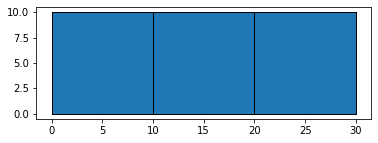

In [74]:
polys = gpd.GeoSeries([poly_1, poly_2, poly_3])
polys.plot(edgecolor='k')

The `GeoSeries` can be thought of as a vector, with each element of the
vector corresponding to one or more Shapely geometry objects:

In [75]:
polys

0    POLYGON ((0.00000 0.00000, 0.00000 10.00000, 1...
1    POLYGON ((10.00000 0.00000, 10.00000 10.00000,...
2    POLYGON ((20.00000 0.00000, 20.00000 10.00000,...
dtype: geometry

so here we see three elements, each of type `POLYGON` along with their
coordinates.

In [76]:
type(polys)

geopandas.geoseries.GeoSeries

Depending on what we need, we can either work on an *element-wise* basis
or with the geoseries as a unified object. For example, an example of
the former is:

In [77]:
polys.bounds

,minx,miny,maxx,maxy
0,0.0,0.0,10.0,10.0
1,10.0,0.0,20.0,10.0
2,20.0,0.0,30.0,10.0


which returns the bounds of each of the polygons. Alternatively, if we
want the bounds for the collection:

In [78]:
polys.total_bounds

array([ 0.,  0., 30., 10.])

Binary operations between two geoseries will be carried out element
wise, and this can lead to some counter intuitive results. For example,
a second `GeoSeries` created as:

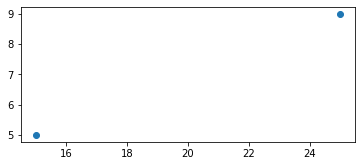

In [79]:
from shapely.geometry import Point
p_1 = Point(15, 5)
p_2 = Point(25, 9)
points = gpd.GeoSeries([p_1, p_2])
points.plot()

consists of two points. Each of the points is contained by the `polys`
`GeoSeries`:

In [80]:
polys.contains(p_1)

0    False
1     True
2    False
dtype: bool

and

In [81]:
polys.contains(p_2)

0    False
1    False
2     True
dtype: bool

Plotting the two `GeoSeries` confirms this:

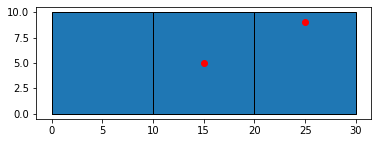

In [82]:
ax = plt.gca()
polys.plot(ax=ax, edgecolor='k')
points.plot(ax=ax, edgecolor='r', facecolor='r')
plt.show()

Yet, when we check if the points as a `GeoSeries` are contained by the
`polys` `GeoSeries` we get:

In [83]:
polys.contains(points)

0    False
1    False
2    False
dtype: bool

This is because the first point is not contained in the first polygon,
and the second point is not contained in the second polygon, while there
is no third point.

A second point geoseries can clarify this:

In [84]:
points = gpd.GeoSeries([Point(5,5), Point(15, 6), Point([25,9])])
polys.contains(points)

0    True
1    True
2    True
dtype: bool

whereas if we change the ordering of the second and third points we get:

In [85]:
points = gpd.GeoSeries([Point(5,5), Point(25, 9), Point([15,6])])
polys.contains(points)

0     True
1    False
2    False
dtype: bool

GeoDataFrame: Putting the Panda in GeoPandas
--------------------------------------------

-   geometry column is populated with a geoseries

In [86]:
polys_df = gpd.GeoDataFrame({'names': ['west', 'central', 'east'], 'geometry': polys})
polys_df

,names,geometry
0,west,"POLYGON ((0.00000 0.00000, 0.00000 10.00000, 1..."
1,central,"POLYGON ((10.00000 0.00000, 10.00000 10.00000,..."
2,east,"POLYGON ((20.00000 0.00000, 20.00000 10.00000,..."


The dataframe provides the ability to add add additional columns:

In [87]:
polys_df['Unemployment'] = [ 7.8, 5.3, 8.2]
polys_df

,names,geometry,Unemployment
0,west,"POLYGON ((0.00000 0.00000, 0.00000 10.00000, 1...",7.8
1,central,"POLYGON ((10.00000 0.00000, 10.00000 10.00000,...",5.3
2,east,"POLYGON ((20.00000 0.00000, 20.00000 10.00000,...",8.2


and it supports different types of subsetting and traditional (i.e.,
nonspatial) queries. For example, find the regions with unemployment
rates above 6 percent:

In [88]:
polys_df[polys_df['Unemployment']>6.0]

,names,geometry,Unemployment
0,west,"POLYGON ((0.00000 0.00000, 0.00000 10.00000, 1...",7.8
2,east,"POLYGON ((20.00000 0.00000, 20.00000 10.00000,...",8.2


There is nothing sacred about the column labeled \'geometry\' in the
GeoDataFrame. Moreover, we can add additional GeoSeries to the same
dataframe, as they will be treated as regular columns. However, only one
GeoSeries can serve as the column against which any spatial methods are
applied when called upon. This column can be accessed through the
`geometry` attribute of the `GeoDataFrame`:

In [89]:
polys_df.geometry

0    POLYGON ((0.00000 0.00000, 0.00000 10.00000, 1...
1    POLYGON ((10.00000 0.00000, 10.00000 10.00000,...
2    POLYGON ((20.00000 0.00000, 20.00000 10.00000,...
Name: geometry, dtype: geometry

Let\'s create a new Points GeoSeries and add it to this GeoDataFrame as
a regular column:

In [90]:
points = gpd.GeoSeries([Point(5,5), Point(15, 6), Point([25,9])])
polys_df['points'] = points
polys_df.geometry

0    POLYGON ((0.00000 0.00000, 0.00000 10.00000, 1...
1    POLYGON ((10.00000 0.00000, 10.00000 10.00000,...
2    POLYGON ((20.00000 0.00000, 20.00000 10.00000,...
Name: geometry, dtype: geometry

So the `polys` column is currently serving as the `geometry` property
for the `GeoDataFrame` and `points` is just another column:

In [91]:
polys_df

,names,geometry,Unemployment,points
0,west,"POLYGON ((0.00000 0.00000, 0.00000 10.00000, 1...",7.8,POINT (5.00000 5.00000)
1,central,"POLYGON ((10.00000 0.00000, 10.00000 10.00000,...",5.3,POINT (15.00000 6.00000)
2,east,"POLYGON ((20.00000 0.00000, 20.00000 10.00000,...",8.2,POINT (25.00000 9.00000)


so when we call the `plot` method we get the polygon representation:

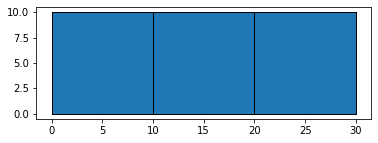

In [92]:
polys_df.plot(edgecolor='k')

However, if we explicity set the geometry property (and assign this to a
new object with the same name), and plot, things change:

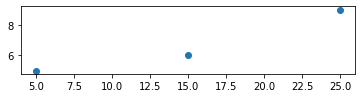

In [93]:
polys_df = polys_df.set_geometry('points')
polys_df.plot()

and this is because

In [94]:
polys_df.geometry

0     POINT (5.00000 5.00000)
1    POINT (15.00000 6.00000)
2    POINT (25.00000 9.00000)
Name: points, dtype: geometry

Read a Polygon Shapefile
========================

In [0]:
tracts_df = gpd.read_file('pysalnarsc19/content/data/california_tracts.shp')

In [96]:
tracts_df.head()

,GEOID10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,DP0010001,DP0010002,DP0010003,DP0010004,DP0010005,DP0010006,DP0010007,DP0010008,DP0010009,DP0010010,DP0010011,DP0010012,DP0010013,DP0010014,DP0010015,DP0010016,DP0010017,DP0010018,DP0010019,DP0010020,DP0010021,DP0010022,DP0010023,DP0010024,DP0010025,DP0010026,DP0010027,DP0010028,DP0010029,DP0010030,DP0010031,DP0010032,DP0010033,DP0010034,...,DP0130001,DP0130002,DP0130003,DP0130004,DP0130005,DP0130006,DP0130007,DP0130008,DP0130009,DP0130010,DP0130011,DP0130012,DP0130013,DP0130014,DP0130015,DP0140001,DP0150001,DP0160001,DP0170001,DP0180001,DP0180002,DP0180003,DP0180004,DP0180005,DP0180006,DP0180007,DP0180008,DP0180009,DP0190001,DP0200001,DP0210001,DP0210002,DP0210003,DP0220001,DP0220002,DP0230001,DP0230002,Shape_Leng,Shape_Area,geometry
0,06083002103,Census Tract 21.03,2838200.0,7603.0,+34.9306689,-120.4270588,3930,354,290,253,254,329,351,312,213,219,218,217,229,177,150,92,91,89,92,1874,170,143,114,130,160,166,152,111,114,105,110,117,89,68,...,1469,866,443,596,293,77,41,193,109,603,503,228,62,275,138,501,365,2.62,3.44,1563,1469,94,66,4,6,4,6,8,1.2,6.2,1469,476,993,1360,2492,2.86,2.51,0.069451,0.000281,"POLYGON ((-120.41794 34.93834, -120.41766 34.9..."
1,06083002402,Census Tract 24.02,16288573.0,44468.0,+34.9287963,-120.4780833,11406,1250,1099,969,1055,963,1063,893,863,714,609,524,400,301,207,153,139,103,101,5788,615,559,512,565,529,539,457,444,365,289,261,202,137,95,...,2920,2366,1543,1681,1093,204,127,481,323,554,409,182,56,227,103,1720,530,3.90,4.15,3041,2920,121,48,0,20,3,8,42,1.4,3.1,2920,1444,1476,5161,6240,3.57,4.23,0.190631,0.001611,"POLYGON ((-120.47389 34.92081, -120.47429 34.9..."
2,06083002102,Census Tract 21.02,1352551.0,0.0,+34.9421111,-120.4267767,2084,156,141,139,154,160,141,129,123,130,152,155,118,111,66,47,47,72,43,1036,74,86,82,95,91,57,69,65,55,65,78,49,64,22,...,739,499,216,355,156,37,13,107,47,240,205,77,22,128,66,248,209,2.82,3.42,779,739,40,10,1,5,4,6,14,1.1,3.2,739,433,306,1179,905,2.72,2.96,0.051289,0.000133,"POLYGON ((-120.41766 34.93835, -120.41794 34.9..."
3,06083002010,Census Tract 20.10,2417990.0,0.0,+34.8714281,-120.4100285,4375,215,264,341,393,213,179,197,226,302,414,427,323,251,177,130,121,113,89,2182,105,139,191,209,119,91,89,108,131,220,197,170,128,88,...,1522,1246,498,1059,409,56,24,131,65,276,223,85,35,138,91,548,444,2.87,3.16,1565,1522,43,8,1,19,2,2,11,1.4,3.5,1522,1303,219,3609,761,2.77,3.47,0.066269,0.000238,"POLYGON ((-120.41147 34.87962, -120.41141 34.8..."
4,06083002009,Census Tract 20.09,2603281.0,0.0,+34.8722878,-120.4277159,3826,170,232,318,377,226,153,155,182,268,317,376,244,200,143,133,131,106,95,1871,95,120,150,202,134,76,75,81,132,153,191,122,104,55,...,1326,1020,438,795,330,61,27,164,81,306,272,91,35,181,135,487,427,2.85,3.26,1397,1326,71,17,3,31,1,3,16,3.1,4.5,1326,969,357,2730,1045,2.82,2.93,0.065523,0.000257,"POLYGON ((-120.42352 34.87928, -120.42286 34.8..."


In [97]:
tracts_df.shape

(8057, 195)

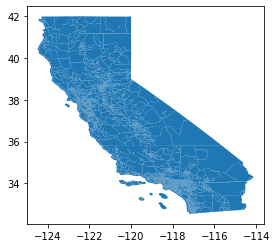

In [98]:
tracts_df.plot()

In [99]:
tracts_df.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [100]:
tracts_df.columns

Index(['GEOID10', 'NAMELSAD10', 'ALAND10', 'AWATER10', 'INTPTLAT10',
       'INTPTLON10', 'DP0010001', 'DP0010002', 'DP0010003', 'DP0010004',
       ...
       'DP0210001', 'DP0210002', 'DP0210003', 'DP0220001', 'DP0220002',
       'DP0230001', 'DP0230002', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object', length=195)

Read a Point Shapefile
======================

In [0]:
clinics_df = gpd.read_file('pysalnarsc19/content/data/behavioralHealth.shp')

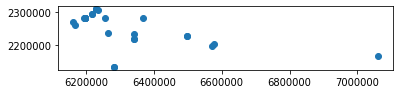

In [102]:
clinics_df.plot()

In [103]:
clinics_df.columns

Index(['OBJECTID', 'SITE_TYPE', 'SITE_NAME', 'ADDRESS', 'CITY', 'ZIPCODE',
       'PHONE', 'geometry'],
      dtype='object')

In [104]:
clinics_df.shape

(28, 8)

In [105]:
clinics_df['geometry'].head()

0    POINT (6216487.156 2291913.664)
1    POINT (6195566.226 2280519.190)
2    POINT (6168252.101 2261023.951)
3    POINT (7059944.605 2169652.046)
4    POINT (6195949.672 2280510.302)
Name: geometry, dtype: geometry

What we want to do now is focus on the relationships between the
locations of these clinics in Riverside county and the census tracts in
that county. We have two issues to deal with in order to do so.

First, our dataframe for the tracts includes all 58 counties, whereas we
only need Riverside county. Second, if you look closely at the plot of
the clinics you will see that the units on the axes are different from
those in the plot of the census tracts. This is because the two
dataframes have different coordinate reference systems (CRS).

Extracting Riverside County Tracts {#riverside-county}
==================================

In [0]:
riverside_tracts = tracts_df[tracts_df['GEOID10'].str.match("^06065")]

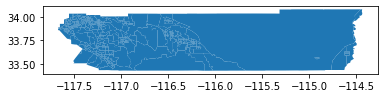

In [107]:
riverside_tracts.plot()

Coordinate Reference Systems
============================

Spatial Joins
=============

Let\'s find out which tracts have clinics.

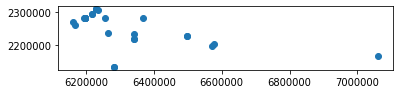

In [108]:
clinics_df.plot()

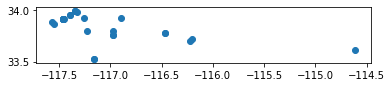

In [109]:
clinics_df.to_crs(riverside_tracts.crs).plot()

In [0]:
# convert crs of clinics to match that of tracts
clinics_df = clinics_df.to_crs(riverside_tracts.crs)

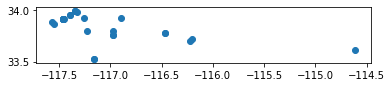

In [111]:
clinics_df.plot()

In [121]:
clinics_tracts = gpd.sjoin(clinics_df, riverside_tracts, op='within')

AttributeError: ignored

In [0]:
clinics_tracts.head()

In [0]:
clinics_tracts.shape

In [0]:
clinics_df.columns

In [0]:
clinics_tracts.columns

In [0]:
# GEOID10 is now attached to each clinic (i.e., tract identifier)

In [0]:
clinics_tracts[['GEOID10', 'index_right']].groupby('GEOID10').agg('count')

In [0]:
clinics_tracts.groupby(['GEOID10']).size()

In [0]:
clinics_tracts.groupby(['GEOID10']).size().reset_index(name='clinics')

In [0]:
twc = clinics_tracts.groupby(['GEOID10']).size().reset_index(name='clinics')

In [0]:
twc.plot()

In [0]:
riverside_tracts_clinics = riverside_tracts.merge(twc, how='left', on='GEOID10')

In [0]:
riverside_tracts_clinics.head()

In [0]:
riverside_tracts_clinics.fillna(value=0, inplace=True)

In [0]:
riverside_tracts_clinics.head()

In [0]:
riverside_tracts_clinics['clinics'].sum()

Writing Shapefiles
==================

In [0]:
# save to a new shapefile
riverside_tracts_clinics.to_file('data/clinics.shp')

---

<a rel="license" href="http://creativecommons.org/licenses/by-nc-
sa/4.0/"><img alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Introduction to GeoPandas</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://sergerey.org" property="cc:attributionName"
rel="cc:attributionURL">Serge Rey</a> is licensed under a <a
rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative
Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.